# **ANN Assignment 1**
# **Muhammad Ali (498148)**

**Solving our NN using basic tensor operations**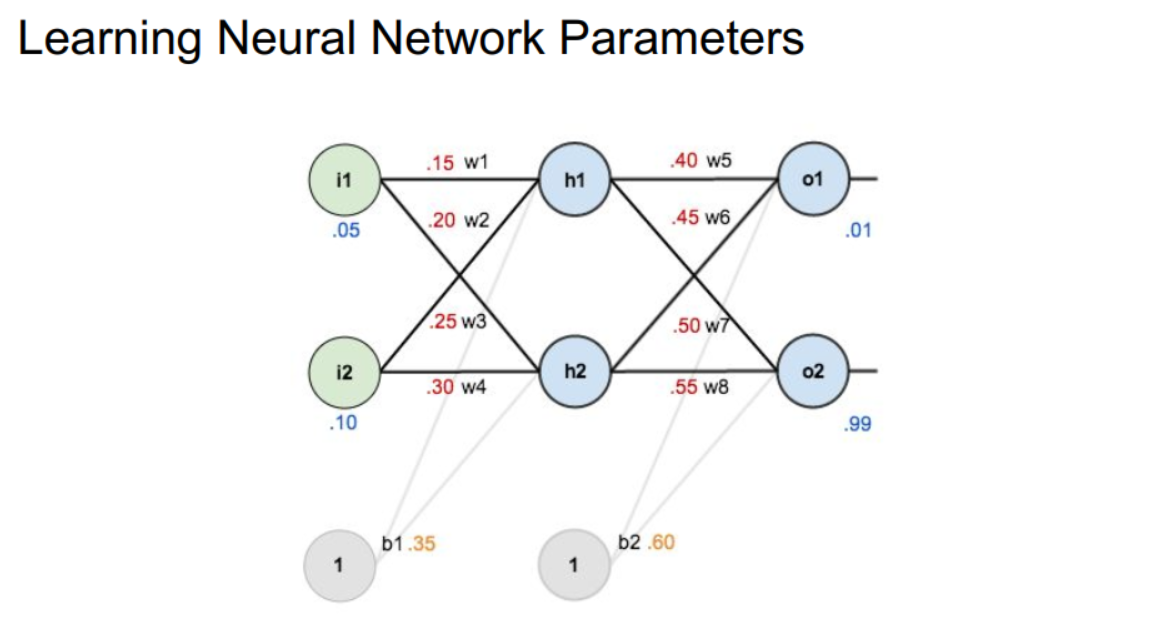

Lets do a single iteration forward and see error

In [1]:
import torch

In [2]:
# Input to our NN
x = torch.tensor([[0.05,0.1]])

# Expected Outputs
o = torch.tensor([[0.01,0.99]])

x

tensor([[0.0500, 0.1000]])

In [3]:
# Weights and biases of 1st layer
w = torch.tensor([[0.15,0.25],
                  [0.20,0.30]], requires_grad=True)
b = torch.tensor(0.35, requires_grad=True)
print(w)
print(b)

tensor([[0.1500, 0.2500],
        [0.2000, 0.3000]], requires_grad=True)
tensor(0.3500, requires_grad=True)


In [4]:
#Layer 1 sigmoid input calculation
y = x @ w + b
y

tensor([[0.3775, 0.3925]], grad_fn=<AddBackward0>)

In [5]:
#Calculating output of 1st layer (Signmoid activation function)
out1 = 1/(1+torch.exp(-y))
out1

tensor([[0.5933, 0.5969]], grad_fn=<MulBackward0>)

In [6]:
# Weights and biases of 2nd layer
w2 = torch.tensor([[0.40,0.50],
                  [0.45,0.55]], requires_grad=True)
b2 = torch.tensor(0.60, requires_grad=True)
print(w2)
print(b2)

tensor([[0.4000, 0.5000],
        [0.4500, 0.5500]], requires_grad=True)
tensor(0.6000, requires_grad=True)


In [7]:
#Layer 2 sigmoid input calculation
y2 = out1 @ w2 + b2
y2

tensor([[1.1059, 1.2249]], grad_fn=<AddBackward0>)

In [8]:
#Calculating output of 2nd layer (Signmoid activation function)
out2 = 1/(1+torch.exp(-y2))
out2

tensor([[0.7514, 0.7729]], grad_fn=<MulBackward0>)

In [9]:
# defining function to calculate MSE loss
def mse(t1, t2):
    diff = t1 - t2
    return torch.sum(torch.square(diff)) / diff.numel()

In [10]:
# Calculate the mean squared error between the predicted and actual output
error = mse(o,out2)
error

tensor(0.2984, grad_fn=<DivBackward0>)

In [11]:
error.backward() # Calculate the gradients of the error with respect to the weights and biases

In [12]:
# Gradients
print(w.grad)
print(b.grad)
print(w2.grad)
print(b2.grad)

tensor([[0.0004, 0.0005],
        [0.0009, 0.0010]])
tensor(0.0187)
tensor([[ 0.0822, -0.0226],
        [ 0.0827, -0.0227]])
tensor(0.1004)


All values match our hand calculated values. Now lets write a function that repeats these steps and update weigth and biases after every iteration

In [13]:
def NN(i, o, w1, b1, w2, b2, it): # NN function takes input, output, weights & bias of hidden and output layer and iterations.
  for j in range(it):             # Loop that runs for it iterations
    y = i @ w1 + b1               # Layer 1 sigmoid input calculation
    out1 = 1/(1+torch.exp(-y))    # Calculating output of 1st layer (Signmoid activation function)
    y2 = out1 @ w2 + b2           # Layer 2 sigmoid input calculation
    out2 = 1/(1+torch.exp(-y2))   # Calculating output of 2nd layer (Signmoid activation function)
    error = mse(o,out2)           # Calculate the mean squared error between the predicted and actual output
    error.backward()              # Calculate the gradients of the error with respect to the weights and biases
    with torch.no_grad():         # Update the weights and biases without tracking gradients
      w1 -= w1.grad * 1e+1        # Update the weights of the first layer using gradient descent. Alpha value was adjusted till error low
      b1 -= b1.grad * 1e+1
      w2 -= w2.grad * 1e+1
      b2 -= b2.grad * 1e+1
    w1.grad.zero_()               # Reset the gradients
    b1.grad.zero_()
    w2.grad.zero_()
    b2.grad.zero_()
  return error , out2             # Return the final error and the predicted output

In [14]:
E, predicted = NN(x,o,w,b,w2,b2,10000)    #Calling our custom function above using defined input, output, weights and biases, 10000 iterations
print("Final Error: ", E.detach().numpy())
print("Predicted Output: ", predicted.detach().numpy())

Final Error:  1.6677285e-12
Predicted Output:  [[0.01000133 0.98999876]]


**Error is close to zero and predicted values are almost equal to output values!**

# **Now we will make same NN using inbuilt Pytorch functions**

In [30]:
import torch.nn as nn
import torch.optim as optim

# Define the neural network model
class SimpleNN(nn.Module):  # Defines a class named SimpleNN, inheriting from nn.Module, the base class for all neural network modules in PyTorch.
    def __init__(self):     # Constructor of the class, initializes the model's layers and parameters.
        super(SimpleNN, self).__init__()  # Calls the constructor of the parent class (nn.Module) to properly initialize the model.
        self.hidden = nn.Linear(2, 2)     # Defines a linear layer named 'hidden' with 2 input features and 2 output features.
        self.output = nn.Linear(2, 2)     # Defines another linear layer named 'output' with 2 input features and 2 output features.

        # Manually setting weights and biases
        with torch.no_grad(): # Disables gradient tracking for the following operations, as we are manually setting the weights and biases.
            self.hidden.weight = nn.Parameter(torch.tensor([[0.15, 0.25],
                                                            [0.20, 0.30]]))
            self.hidden.bias = nn.Parameter(torch.tensor([0.35, 0.35], dtype=torch.float32))

            self.output.weight = nn.Parameter(torch.tensor([[0.40, 0.50],
                                                            [0.45, 0.55]]))
            self.output.bias = nn.Parameter(torch.tensor([0.60, 0.60], dtype=torch.float32))

    def forward(self, x):                 # Defines the forward pass of the model, specifying how the input data flows through the layers.
        x = torch.sigmoid(self.hidden(x)) # Applies the hidden layer to the input 'x' and then applies the sigmoid activation function.
        x = torch.sigmoid(self.output(x)) # Applies the output layer to the result from the previous step and then applies the sigmoid activation function again.
        return x                          # Returns the final output of the model.

In [32]:
# Initialize model, loss function, and optimizer
model = SimpleNN()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e+1)  #Setting learning rate same as we did previosuly

# Training loop
iterations = 10000                    #Iteration are same as previous solution
for j in range(iterations):
    optimizer.zero_grad()             # Reset gradients
    predictions = model(x)            # Forward pass with input same as we difined initially
    loss = criterion(predictions, o)  # Compute loss using predicted and out output values
    loss.backward()                   # Backpropagation
    optimizer.step()                  # Update weights

# Print final Error
E = criterion(model(x), o)
print("Final Error: ", E.item())

# Final output
print("Predicted Output: ", model(x).detach().numpy())

Final Error:  2.3393960379980427e-13
Predicted Output:  [[0.01000054 0.9899996 ]]


**Here again error is close to zero and predicted values are almost equal to output values.**